In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile


In [ ]:
# Setup paths for local execution
import os
import sys

# Project directories
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
SRC_DIR = os.path.join(BASE_DIR, 'src')

# Add src to path
sys.path.insert(0, SRC_DIR)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
data = pd.read_csv('../../data/cleaned_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
max_date = pd.to_datetime(data['ds']).max()

In [5]:
mx1_dt = (max_date - pd.to_timedelta(48, unit='d'))

In [6]:
mx1_dt

Timestamp('2011-09-18 00:00:00')

In [7]:
data.drop(['Unnamed: 0','cumsum','StockCode','Country','max_date','data_not_available_from'],axis=1,inplace=True)

In [8]:
data.head()

,id_var,Quantity,month,dow,qtr,year,holiday,ds
0,Australia_15036,600.0,5,1,2,2011,0,2011-05-17
1,Australia_15036,0.0,5,2,2,2011,0,2011-05-18
2,Australia_15036,0.0,5,3,2,2011,0,2011-05-19
3,Australia_15036,0.0,5,4,2,2011,0,2011-05-20
4,Australia_15036,0.0,5,5,2,2011,0,2011-05-21


In [9]:
data['ds'] = pd.to_datetime(data['ds'])
train = data.loc[data['ds'] <= mx1_dt,]

In [47]:
val = data.loc[data['ds'] > mx1_dt,]
val_f = val[[x for x in val.columns if x != 'Quantity']]
val_f.index = val['ds']
val_f = val_f.drop(['ds'],axis=1)

In [45]:
train_f = train[[x for x in train.columns if x != 'Quantity']]
train_f.index = train.ds
train_f = train_f.drop(['ds'],axis=1)

In [48]:
train_f.head()

,id_var,month,dow,qtr,year,holiday
ds,,,,,,
2011-05-17,Australia_15036,5,1,2,2011,0
2011-05-18,Australia_15036,5,2,2,2011,0
2011-05-19,Australia_15036,5,3,2,2011,0
2011-05-20,Australia_15036,5,4,2,2011,0
2011-05-21,Australia_15036,5,5,2,2011,0


In [10]:
mx_dt = (train['ds'].max() - pd.to_timedelta(28, unit='d'))

In [11]:
mx_dt

Timestamp('2011-08-21 00:00:00')

In [12]:
train1 = train.loc[train['ds'] <= mx_dt,]
train1.index = train1['ds']
train1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
val1 = train.loc[train['ds'] >  mx_dt,]

In [14]:
val1.index = val1['ds']
val1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
val1.index.max()

Timestamp('2011-09-18 00:00:00')

In [16]:
test = data.loc[data['ds'] > val1.index.max(),]

In [17]:
test.index = test['ds']
test.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
train_x = train1[[x for x in train1.columns if x != 'Quantity']]

In [19]:
train_y = train1['Quantity']

In [20]:
import category_encoders as ce

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
id_encoder =  ce.OrdinalEncoder()

In [22]:
id_encoder.fit(train_x['id_var'])
train_x['id_cat'] = id_encoder.transform(train_x['id_var'])

In [23]:
train_x1 = train_x.drop(['id_var'],axis=1)

In [24]:
train_x1

,month,dow,qtr,year,holiday,id_cat
ds,,,,,,
2011-05-17,5,1,2,2011,0,1
2011-05-18,5,2,2,2011,0,1
2011-05-19,5,3,2,2011,0,1
2011-05-20,5,4,2,2011,0,1
2011-05-21,5,5,2,2011,0,1
...,...,...,...,...,...,...
2011-08-17,8,2,3,2011,-1,16961
2011-08-18,8,3,3,2011,-1,16961
2011-08-19,8,4,3,2011,-1,16961


In [25]:
categorical_feature = ['id_cat','month','dow','qtr','holiday']

In [26]:
val_x = val1[[x for x in val1.columns if x != 'Quantity']]
val_y = val1['Quantity']

In [27]:
val_x.head()

,id_var,month,dow,qtr,year,holiday
ds,,,,,,
2011-08-22,Australia_15036,8,0,3,2011,0
2011-08-23,Australia_15036,8,1,3,2011,0
2011-08-24,Australia_15036,8,2,3,2011,0
2011-08-25,Australia_15036,8,3,3,2011,0
2011-08-26,Australia_15036,8,4,3,2011,0


In [28]:
val_x['id_cat'] = id_encoder.transform(val_x['id_var'])
val_x1 = val_x.drop(['id_var'],axis=1)

In [29]:
val_x1

,month,dow,qtr,year,holiday,id_cat
ds,,,,,,
2011-08-22,8,0,3,2011,0,1.0
2011-08-23,8,1,3,2011,0,1.0
2011-08-24,8,2,3,2011,0,1.0
2011-08-25,8,3,3,2011,0,1.0
2011-08-26,8,4,3,2011,0,1.0
...,...,...,...,...,...,...
2011-09-14,9,2,3,2011,-1,16961.0
2011-09-15,9,3,3,2011,-1,16961.0
2011-09-16,9,4,3,2011,-1,16961.0


In [40]:
test_x = test[[x for x in test.columns if x != 'Quantity']]
test_x['id_cat'] = id_encoder.transform(test_x['id_var'])
test_x1 = test_x.drop(['id_var'],axis=1)

In [49]:
train_f['id_cat'] = id_encoder.transform(train_f['id_var'])
train_f = train_f.drop(['id_var'],axis=1)


In [51]:
train_fy = train['Quantity']

In [52]:
val_f['id_cat'] = id_encoder.transform(val_f['id_var'])
val_f.drop(['id_var'],axis=1,inplace=True)
val_fy = val['Quantity']

In [30]:
import optuna
# import optuna.integration.lightgbm as lgb
from optuna.integration.lightgbm import LightGBMTuner


In [31]:
params = {
    'objective': 'tweedie',
    'boosting_type':'gbdt',
    "eval_metric":'mape',
    'metric':'mape'


}

In [32]:
categorical_feature

['id_cat', 'month', 'dow', 'qtr', 'holiday']

In [64]:
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)


In [35]:
tuned_model = LightGBMTuner(params, train_set=lgb_train,
                                     valid_sets=lgb_valid,
                                     num_boost_round=300,
                                     early_stopping_rounds=30,
                                    )

[I 2021-02-17 17:45:43,499] A new study created in memory with name: no-name-22ddeaac-af05-46e9-94b0-771c1630d8ef


In [36]:
tuned_model.run()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['dow', 'holiday', 'id_cat', 'month', 'qtr']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's mape: 0.655245
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.617525
[3]	valid_0's mape: 0.584506
[4]	valid_0's mape: 0.550119
[5]	valid_0's mape: 0.523912
[6]	valid_0's mape: 0.504764
[7]	valid_0's mape: 0.488719
[8]	valid_0's mape: 0.472943
[9]	valid_0's mape: 0.461022
[10]	valid_0's mape: 0.449758
[11]	valid_0's mape: 0.445233
[12]	valid_0's mape: 0.442629
[13]	valid_0's mape: 0.435246
[14]	valid_0's mape: 0.429177
[15]	valid_0's mape: 0.421271
[16]	valid_0's mape: 0.411613
[17]	valid_0's mape: 0.406636
[18]	valid_0's mape: 0.40413
[19]	valid_0's mape: 0.400036
[20]	valid_0's mape: 0.398617
[21]	valid_0's mape: 0.396729
[22]	valid_0's mape: 0.396083
[23]	valid_0's mape: 0.394052
[24]	valid_0's mape: 0.391208
[25]	valid_0's mape: 0.393113
[26]	valid_0's mape: 0.391667
[27]	valid_0's mape: 0.390454
[28]	valid_0's mape: 0.390571
[29]	valid_0's mape: 0.388638
[30]	valid_0's mape: 0.388343
[31]	valid_0's mape: 0.388059
[32]	valid_0's map

feature_fraction, val_score: 0.352483:  14%|#4        | 1/7 [02:26<14:38, 146.42s/it]

[115]	valid_0's mape: 0.356399
Early stopping, best iteration is:
[85]	valid_0's mape: 0.352483
[1]	valid_0's mape: 0.65653
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.619464
[3]	valid_0's mape: 0.58927
[4]	valid_0's mape: 0.565575
[5]	valid_0's mape: 0.540157
[6]	valid_0's mape: 0.519496
[7]	valid_0's mape: 0.498114
[8]	valid_0's mape: 0.482104
[9]	valid_0's mape: 0.470808
[10]	valid_0's mape: 0.459926
[11]	valid_0's mape: 0.454896
[12]	valid_0's mape: 0.448013
[13]	valid_0's mape: 0.444778
[14]	valid_0's mape: 0.434834
[15]	valid_0's mape: 0.424966
[16]	valid_0's mape: 0.426947
[17]	valid_0's mape: 0.425804
[18]	valid_0's mape: 0.421372
[19]	valid_0's mape: 0.422154
[20]	valid_0's mape: 0.422529
[21]	valid_0's mape: 0.417417
[22]	valid_0's mape: 0.408653
[23]	valid_0's mape: 0.40354
[24]	valid_0's mape: 0.402604
[25]	valid_0's mape: 0.401597
[26]	valid_0's mape: 0.398798
[27]	valid_0's mape: 0.395694
[28]	valid_0's mape: 0.39128
[29]	valid_0's 

feature_fraction, val_score: 0.352483:  29%|##8       | 2/7 [05:03<12:27, 149.47s/it]

[122]	valid_0's mape: 0.361024
Early stopping, best iteration is:
[92]	valid_0's mape: 0.358499


[I 2021-02-17 17:51:37,271] Trial 1 finished with value: 0.3584989317420098 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.352483305740956.
feature_fraction, val_score: 0.352483:  29%|##8       | 2/7 [05:03<12:27, 149.47s/it]

[1]	valid_0's mape: 0.653367
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.626124
[3]	valid_0's mape: 0.597868
[4]	valid_0's mape: 0.559779
[5]	valid_0's mape: 0.562483
[6]	valid_0's mape: 0.548595
[7]	valid_0's mape: 0.522116
[8]	valid_0's mape: 0.498966
[9]	valid_0's mape: 0.487428
[10]	valid_0's mape: 0.470893
[11]	valid_0's mape: 0.463447
[12]	valid_0's mape: 0.45577
[13]	valid_0's mape: 0.450119
[14]	valid_0's mape: 0.444887
[15]	valid_0's mape: 0.438511
[16]	valid_0's mape: 0.435799
[17]	valid_0's mape: 0.432102
[18]	valid_0's mape: 0.420935
[19]	valid_0's mape: 0.412478
[20]	valid_0's mape: 0.407384
[21]	valid_0's mape: 0.40155
[22]	valid_0's mape: 0.398393
[23]	valid_0's mape: 0.394478
[24]	valid_0's mape: 0.392064
[25]	valid_0's mape: 0.391045
[26]	valid_0's mape: 0.381651
[27]	valid_0's mape: 0.378485
[28]	valid_0's mape: 0.376571
[29]	valid_0's mape: 0.375101
[30]	valid_0's mape: 0.374328
[31]	valid_0's mape: 0.372871
[32]	valid_0's mape

feature_fraction, val_score: 0.350131:  43%|####2     | 3/7 [07:50<10:19, 154.82s/it]

[141]	valid_0's mape: 0.350903
Early stopping, best iteration is:
[111]	valid_0's mape: 0.350131
[1]	valid_0's mape: 0.663989
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.639191
[3]	valid_0's mape: 0.644268
[4]	valid_0's mape: 0.615738
[5]	valid_0's mape: 0.598144
[6]	valid_0's mape: 0.582229
[7]	valid_0's mape: 0.554654
[8]	valid_0's mape: 0.553328
[9]	valid_0's mape: 0.540463
[10]	valid_0's mape: 0.530941
[11]	valid_0's mape: 0.515095
[12]	valid_0's mape: 0.502147
[13]	valid_0's mape: 0.483097
[14]	valid_0's mape: 0.465305
[15]	valid_0's mape: 0.458437
[16]	valid_0's mape: 0.452985
[17]	valid_0's mape: 0.452688
[18]	valid_0's mape: 0.439232
[19]	valid_0's mape: 0.435765
[20]	valid_0's mape: 0.435828
[21]	valid_0's mape: 0.430535
[22]	valid_0's mape: 0.427907
[23]	valid_0's mape: 0.42809
[24]	valid_0's mape: 0.423611
[25]	valid_0's mape: 0.424832
[26]	valid_0's mape: 0.421036
[27]	valid_0's mape: 0.419007
[28]	valid_0's mape: 0.421645
[29]	valid_

feature_fraction, val_score: 0.350131:  57%|#####7    | 4/7 [09:22<06:48, 136.11s/it]

[97]	valid_0's mape: 0.37157
Early stopping, best iteration is:
[67]	valid_0's mape: 0.365943
[1]	valid_0's mape: 0.653367
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.626124
[3]	valid_0's mape: 0.597868
[4]	valid_0's mape: 0.559779
[5]	valid_0's mape: 0.562483
[6]	valid_0's mape: 0.548595
[7]	valid_0's mape: 0.522116
[8]	valid_0's mape: 0.498966
[9]	valid_0's mape: 0.487428
[10]	valid_0's mape: 0.470893
[11]	valid_0's mape: 0.463447
[12]	valid_0's mape: 0.45577
[13]	valid_0's mape: 0.450119
[14]	valid_0's mape: 0.444887
[15]	valid_0's mape: 0.438511
[16]	valid_0's mape: 0.435799
[17]	valid_0's mape: 0.432102
[18]	valid_0's mape: 0.420935
[19]	valid_0's mape: 0.412478
[20]	valid_0's mape: 0.407384
[21]	valid_0's mape: 0.40155
[22]	valid_0's mape: 0.398393
[23]	valid_0's mape: 0.394478
[24]	valid_0's mape: 0.392064
[25]	valid_0's mape: 0.391045
[26]	valid_0's mape: 0.381651
[27]	valid_0's mape: 0.378485
[28]	valid_0's mape: 0.376571
[29]	valid_0's 

feature_fraction, val_score: 0.350131:  71%|#######1  | 5/7 [11:55<04:41, 140.94s/it]

[141]	valid_0's mape: 0.350903
Early stopping, best iteration is:
[111]	valid_0's mape: 0.350131
[1]	valid_0's mape: 0.654327
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.625363
[3]	valid_0's mape: 0.586837
[4]	valid_0's mape: 0.555873
[5]	valid_0's mape: 0.530769
[6]	valid_0's mape: 0.511205
[7]	valid_0's mape: 0.487566
[8]	valid_0's mape: 0.478283
[9]	valid_0's mape: 0.462183
[10]	valid_0's mape: 0.456603
[11]	valid_0's mape: 0.447155
[12]	valid_0's mape: 0.437278
[13]	valid_0's mape: 0.428201
[14]	valid_0's mape: 0.421272
[15]	valid_0's mape: 0.419286
[16]	valid_0's mape: 0.4193
[17]	valid_0's mape: 0.41185
[18]	valid_0's mape: 0.407497
[19]	valid_0's mape: 0.397855
[20]	valid_0's mape: 0.393089
[21]	valid_0's mape: 0.38827
[22]	valid_0's mape: 0.385378
[23]	valid_0's mape: 0.381515
[24]	valid_0's mape: 0.378414
[25]	valid_0's mape: 0.378664
[26]	valid_0's mape: 0.379854
[27]	valid_0's mape: 0.378721
[28]	valid_0's mape: 0.37692
[29]	valid_0's 

feature_fraction, val_score: 0.350131:  86%|########5 | 6/7 [13:56<02:15, 135.11s/it]

[103]	valid_0's mape: 0.358139
Early stopping, best iteration is:
[73]	valid_0's mape: 0.357582
[1]	valid_0's mape: 0.654327
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.625363
[3]	valid_0's mape: 0.586837
[4]	valid_0's mape: 0.555873
[5]	valid_0's mape: 0.530769
[6]	valid_0's mape: 0.511205
[7]	valid_0's mape: 0.487566
[8]	valid_0's mape: 0.478283
[9]	valid_0's mape: 0.462183
[10]	valid_0's mape: 0.456603
[11]	valid_0's mape: 0.447155
[12]	valid_0's mape: 0.437278
[13]	valid_0's mape: 0.428201
[14]	valid_0's mape: 0.421272
[15]	valid_0's mape: 0.419286
[16]	valid_0's mape: 0.4193
[17]	valid_0's mape: 0.41185
[18]	valid_0's mape: 0.407497
[19]	valid_0's mape: 0.397855
[20]	valid_0's mape: 0.393089
[21]	valid_0's mape: 0.38827
[22]	valid_0's mape: 0.385378
[23]	valid_0's mape: 0.381515
[24]	valid_0's mape: 0.378414
[25]	valid_0's mape: 0.378664
[26]	valid_0's mape: 0.379854
[27]	valid_0's mape: 0.378721
[28]	valid_0's mape: 0.37692
[29]	valid_0's m

num_leaves, val_score: 0.350131:   0%|          | 0/20 [00:00<?, ?it/s]

[103]	valid_0's mape: 0.358139
Early stopping, best iteration is:
[73]	valid_0's mape: 0.357582
[1]	valid_0's mape: 0.633595
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.602574
[3]	valid_0's mape: 0.574039
[4]	valid_0's mape: 0.523532
[5]	valid_0's mape: 0.527347
[6]	valid_0's mape: 0.514152
[7]	valid_0's mape: 0.4781
[8]	valid_0's mape: 0.447958
[9]	valid_0's mape: 0.437651
[10]	valid_0's mape: 0.416406
[11]	valid_0's mape: 0.409837
[12]	valid_0's mape: 0.402225
[13]	valid_0's mape: 0.397316
[14]	valid_0's mape: 0.391177
[15]	valid_0's mape: 0.387408
[16]	valid_0's mape: 0.384231
[17]	valid_0's mape: 0.379919
[18]	valid_0's mape: 0.365256
[19]	valid_0's mape: 0.352886
[20]	valid_0's mape: 0.349424
[21]	valid_0's mape: 0.343591
[22]	valid_0's mape: 0.339421
[23]	valid_0's mape: 0.337057
[24]	valid_0's mape: 0.333371
[25]	valid_0's mape: 0.332462
[26]	valid_0's mape: 0.327758
[27]	valid_0's mape: 0.324629
[28]	valid_0's mape: 0.323045
[29]	valid_0'

num_leaves, val_score: 0.320586:   5%|5         | 1/20 [01:55<36:28, 115.17s/it]

[67]	valid_0's mape: 0.332122
Early stopping, best iteration is:
[37]	valid_0's mape: 0.320586


[I 2021-02-17 18:04:25,258] Trial 7 finished with value: 0.3205862768133987 and parameters: {'num_leaves': 125}. Best is trial 7 with value: 0.3205862768133987.
num_leaves, val_score: 0.320586:   5%|5         | 1/20 [01:55<36:28, 115.17s/it]

[1]	valid_0's mape: 0.62852
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.596881
[3]	valid_0's mape: 0.568623
[4]	valid_0's mape: 0.516154
[5]	valid_0's mape: 0.520083
[6]	valid_0's mape: 0.507057
[7]	valid_0's mape: 0.466578
[8]	valid_0's mape: 0.436507
[9]	valid_0's mape: 0.426734
[10]	valid_0's mape: 0.404206
[11]	valid_0's mape: 0.397999
[12]	valid_0's mape: 0.390744
[13]	valid_0's mape: 0.386115
[14]	valid_0's mape: 0.380267
[15]	valid_0's mape: 0.376587
[16]	valid_0's mape: 0.373619
[17]	valid_0's mape: 0.36949
[18]	valid_0's mape: 0.355378
[19]	valid_0's mape: 0.343204
[20]	valid_0's mape: 0.339972
[21]	valid_0's mape: 0.332926
[22]	valid_0's mape: 0.327349
[23]	valid_0's mape: 0.325281
[24]	valid_0's mape: 0.321605
[25]	valid_0's mape: 0.320917
[26]	valid_0's mape: 0.317313
[27]	valid_0's mape: 0.315289
[28]	valid_0's mape: 0.31388
[29]	valid_0's mape: 0.31344
[30]	valid_0's mape: 0.313261
[31]	valid_0's mape: 0.315149
[32]	valid_0's mape: 

num_leaves, val_score: 0.313261:  10%|#         | 2/20 [03:53<34:48, 116.05s/it]

[1]	valid_0's mape: 0.630675
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.598953
[3]	valid_0's mape: 0.570596
[4]	valid_0's mape: 0.518765
[5]	valid_0's mape: 0.522705
[6]	valid_0's mape: 0.512322
[7]	valid_0's mape: 0.473784
[8]	valid_0's mape: 0.443295
[9]	valid_0's mape: 0.433193
[10]	valid_0's mape: 0.411277
[11]	valid_0's mape: 0.404862
[12]	valid_0's mape: 0.397369
[13]	valid_0's mape: 0.392578
[14]	valid_0's mape: 0.386529
[15]	valid_0's mape: 0.381664
[16]	valid_0's mape: 0.378649
[17]	valid_0's mape: 0.374387
[18]	valid_0's mape: 0.35949
[19]	valid_0's mape: 0.347588
[20]	valid_0's mape: 0.344245
[21]	valid_0's mape: 0.337658
[22]	valid_0's mape: 0.331964
[23]	valid_0's mape: 0.329851
[24]	valid_0's mape: 0.326246
[25]	valid_0's mape: 0.325569
[26]	valid_0's mape: 0.32185
[27]	valid_0's mape: 0.319338
[28]	valid_0's mape: 0.317883
[29]	valid_0's mape: 0.317599
[30]	valid_0's mape: 0.31751
[31]	valid_0's mape: 0.319421
[32]	valid_0's mape:

num_leaves, val_score: 0.313261:  15%|#5        | 3/20 [05:55<33:25, 117.96s/it]

[1]	valid_0's mape: 0.639702
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.610438
[3]	valid_0's mape: 0.581558
[4]	valid_0's mape: 0.536334
[5]	valid_0's mape: 0.540145
[6]	valid_0's mape: 0.526701
[7]	valid_0's mape: 0.489471
[8]	valid_0's mape: 0.461024
[9]	valid_0's mape: 0.450097
[10]	valid_0's mape: 0.429594
[11]	valid_0's mape: 0.422509
[12]	valid_0's mape: 0.414521
[13]	valid_0's mape: 0.409207
[14]	valid_0's mape: 0.402769
[15]	valid_0's mape: 0.398888
[16]	valid_0's mape: 0.394731
[17]	valid_0's mape: 0.390224
[18]	valid_0's mape: 0.376493
[19]	valid_0's mape: 0.364689
[20]	valid_0's mape: 0.361018
[21]	valid_0's mape: 0.355435
[22]	valid_0's mape: 0.353012
[23]	valid_0's mape: 0.350344
[24]	valid_0's mape: 0.345835
[25]	valid_0's mape: 0.345417
[26]	valid_0's mape: 0.339185
[27]	valid_0's mape: 0.335873
[28]	valid_0's mape: 0.334205
[29]	valid_0's mape: 0.334025
[30]	valid_0's mape: 0.333227
[31]	valid_0's mape: 0.334945
[32]	valid_0's ma

num_leaves, val_score: 0.313261:  20%|##        | 4/20 [07:37<30:07, 112.99s/it]

[67]	valid_0's mape: 0.337464
Early stopping, best iteration is:
[37]	valid_0's mape: 0.329225
[1]	valid_0's mape: 0.647195
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.616931
[3]	valid_0's mape: 0.588392
[4]	valid_0's mape: 0.547029
[5]	valid_0's mape: 0.55088
[6]	valid_0's mape: 0.537162
[7]	valid_0's mape: 0.505383
[8]	valid_0's mape: 0.478918
[9]	valid_0's mape: 0.467598
[10]	valid_0's mape: 0.448465
[11]	valid_0's mape: 0.440943
[12]	valid_0's mape: 0.433029
[13]	valid_0's mape: 0.427477
[14]	valid_0's mape: 0.420954
[15]	valid_0's mape: 0.416904
[16]	valid_0's mape: 0.414241
[17]	valid_0's mape: 0.40836
[18]	valid_0's mape: 0.395267
[19]	valid_0's mape: 0.385404
[20]	valid_0's mape: 0.381211
[21]	valid_0's mape: 0.374533
[22]	valid_0's mape: 0.371658
[23]	valid_0's mape: 0.368545
[24]	valid_0's mape: 0.36565
[25]	valid_0's mape: 0.365212
[26]	valid_0's mape: 0.357354
[27]	valid_0's mape: 0.35409
[28]	valid_0's mape: 0.352174
[29]	valid_0's m

num_leaves, val_score: 0.313261:  25%|##5       | 5/20 [09:49<29:43, 118.92s/it]

[99]	valid_0's mape: 0.341817
Early stopping, best iteration is:
[69]	valid_0's mape: 0.339224
[1]	valid_0's mape: 0.649243
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.618907
[3]	valid_0's mape: 0.589894
[4]	valid_0's mape: 0.550859
[5]	valid_0's mape: 0.554366
[6]	valid_0's mape: 0.540518
[7]	valid_0's mape: 0.507042
[8]	valid_0's mape: 0.481277
[9]	valid_0's mape: 0.47023
[10]	valid_0's mape: 0.45172
[11]	valid_0's mape: 0.444333
[12]	valid_0's mape: 0.436732
[13]	valid_0's mape: 0.431217
[14]	valid_0's mape: 0.42461
[15]	valid_0's mape: 0.418832
[16]	valid_0's mape: 0.416035
[17]	valid_0's mape: 0.411315
[18]	valid_0's mape: 0.399017
[19]	valid_0's mape: 0.389662
[20]	valid_0's mape: 0.385267
[21]	valid_0's mape: 0.379975
[22]	valid_0's mape: 0.377915
[23]	valid_0's mape: 0.374401
[24]	valid_0's mape: 0.371991
[25]	valid_0's mape: 0.371576
[26]	valid_0's mape: 0.362108
[27]	valid_0's mape: 0.358767
[28]	valid_0's mape: 0.356861
[29]	valid_0's 

num_leaves, val_score: 0.313261:  30%|###       | 6/20 [11:53<28:06, 120.44s/it]

[96]	valid_0's mape: 0.349569
Early stopping, best iteration is:
[66]	valid_0's mape: 0.347663
[1]	valid_0's mape: 0.629637
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.597964
[3]	valid_0's mape: 0.56966
[4]	valid_0's mape: 0.517995
[5]	valid_0's mape: 0.52194
[6]	valid_0's mape: 0.508871
[7]	valid_0's mape: 0.468325
[8]	valid_0's mape: 0.438242
[9]	valid_0's mape: 0.428346
[10]	valid_0's mape: 0.406601
[11]	valid_0's mape: 0.400321
[12]	valid_0's mape: 0.392995
[13]	valid_0's mape: 0.38831
[14]	valid_0's mape: 0.382405
[15]	valid_0's mape: 0.37871
[16]	valid_0's mape: 0.375713
[17]	valid_0's mape: 0.371545
[18]	valid_0's mape: 0.356505
[19]	valid_0's mape: 0.344413
[20]	valid_0's mape: 0.341233
[21]	valid_0's mape: 0.334602
[22]	valid_0's mape: 0.32936
[23]	valid_0's mape: 0.327336
[24]	valid_0's mape: 0.324075
[25]	valid_0's mape: 0.323382
[26]	valid_0's mape: 0.319709
[27]	valid_0's mape: 0.317582
[28]	valid_0's mape: 0.316132
[29]	valid_0's ma

num_leaves, val_score: 0.313261:  35%|###5      | 7/20 [14:13<27:20, 126.20s/it]

[1]	valid_0's mape: 0.630014
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.598329
[3]	valid_0's mape: 0.570003
[4]	valid_0's mape: 0.518046
[5]	valid_0's mape: 0.521988
[6]	valid_0's mape: 0.51159
[7]	valid_0's mape: 0.471263
[8]	valid_0's mape: 0.441065
[9]	valid_0's mape: 0.431106
[10]	valid_0's mape: 0.409194
[11]	valid_0's mape: 0.402849
[12]	valid_0's mape: 0.395465
[13]	valid_0's mape: 0.390728
[14]	valid_0's mape: 0.384775
[15]	valid_0's mape: 0.37999
[16]	valid_0's mape: 0.376952
[17]	valid_0's mape: 0.372762
[18]	valid_0's mape: 0.358106
[19]	valid_0's mape: 0.34603
[20]	valid_0's mape: 0.342798
[21]	valid_0's mape: 0.336202
[22]	valid_0's mape: 0.330382
[23]	valid_0's mape: 0.328348
[24]	valid_0's mape: 0.325305
[25]	valid_0's mape: 0.324647
[26]	valid_0's mape: 0.321146
[27]	valid_0's mape: 0.318905
[28]	valid_0's mape: 0.31743
[29]	valid_0's mape: 0.317518
[30]	valid_0's mape: 0.317456
[31]	valid_0's mape: 0.319323
[32]	valid_0's mape: 

num_leaves, val_score: 0.313261:  40%|####      | 8/20 [16:16<25:04, 125.35s/it]

[1]	valid_0's mape: 0.634045
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.603419
[3]	valid_0's mape: 0.574849
[4]	valid_0's mape: 0.524504
[5]	valid_0's mape: 0.528327
[6]	valid_0's mape: 0.517932
[7]	valid_0's mape: 0.480977
[8]	valid_0's mape: 0.450831
[9]	valid_0's mape: 0.440388
[10]	valid_0's mape: 0.419418
[11]	valid_0's mape: 0.412742
[12]	valid_0's mape: 0.405035
[13]	valid_0's mape: 0.400042
[14]	valid_0's mape: 0.393829
[15]	valid_0's mape: 0.388816
[16]	valid_0's mape: 0.385623
[17]	valid_0's mape: 0.381272
[18]	valid_0's mape: 0.366724
[19]	valid_0's mape: 0.354373
[20]	valid_0's mape: 0.350851
[21]	valid_0's mape: 0.345307
[22]	valid_0's mape: 0.339814
[23]	valid_0's mape: 0.337383
[24]	valid_0's mape: 0.33379
[25]	valid_0's mape: 0.332874
[26]	valid_0's mape: 0.327987
[27]	valid_0's mape: 0.324929
[28]	valid_0's mape: 0.323335
[29]	valid_0's mape: 0.323198
[30]	valid_0's mape: 0.322626
[31]	valid_0's mape: 0.324415
[32]	valid_0's map

num_leaves, val_score: 0.313261:  45%|####5     | 9/20 [18:13<22:30, 122.75s/it]

[67]	valid_0's mape: 0.333862
Early stopping, best iteration is:
[37]	valid_0's mape: 0.321306


[I 2021-02-17 18:20:43,603] Trial 15 finished with value: 0.32130577648466035 and parameters: {'num_leaves': 123}. Best is trial 8 with value: 0.3132613420788353.
num_leaves, val_score: 0.313261:  45%|####5     | 9/20 [18:13<22:30, 122.75s/it]

[1]	valid_0's mape: 0.62852
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.596881
[3]	valid_0's mape: 0.568623
[4]	valid_0's mape: 0.515748
[5]	valid_0's mape: 0.519679
[6]	valid_0's mape: 0.506663
[7]	valid_0's mape: 0.466123
[8]	valid_0's mape: 0.436269
[9]	valid_0's mape: 0.426504
[10]	valid_0's mape: 0.403818
[11]	valid_0's mape: 0.397615
[12]	valid_0's mape: 0.39036
[13]	valid_0's mape: 0.385732
[14]	valid_0's mape: 0.379878
[15]	valid_0's mape: 0.375167
[16]	valid_0's mape: 0.372191
[17]	valid_0's mape: 0.368076
[18]	valid_0's mape: 0.354095
[19]	valid_0's mape: 0.34187
[20]	valid_0's mape: 0.338624
[21]	valid_0's mape: 0.331655
[22]	valid_0's mape: 0.325518
[23]	valid_0's mape: 0.323531
[24]	valid_0's mape: 0.320119
[25]	valid_0's mape: 0.319441
[26]	valid_0's mape: 0.315813
[27]	valid_0's mape: 0.31389
[28]	valid_0's mape: 0.312499
[29]	valid_0's mape: 0.312604
[30]	valid_0's mape: 0.312594
[31]	valid_0's mape: 0.31447
[32]	valid_0's mape: 0

num_leaves, val_score: 0.312499:  50%|#####     | 10/20 [20:11<20:13, 121.36s/it]

[1]	valid_0's mape: 0.62852
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.596881
[3]	valid_0's mape: 0.568623
[4]	valid_0's mape: 0.515618
[5]	valid_0's mape: 0.51955
[6]	valid_0's mape: 0.509149
[7]	valid_0's mape: 0.468254
[8]	valid_0's mape: 0.438525
[9]	valid_0's mape: 0.428687
[10]	valid_0's mape: 0.405657
[11]	valid_0's mape: 0.39942
[12]	valid_0's mape: 0.392124
[13]	valid_0's mape: 0.387472
[14]	valid_0's mape: 0.381586
[15]	valid_0's mape: 0.377868
[16]	valid_0's mape: 0.374894
[17]	valid_0's mape: 0.370745
[18]	valid_0's mape: 0.356738
[19]	valid_0's mape: 0.344285
[20]	valid_0's mape: 0.340996
[21]	valid_0's mape: 0.333973
[22]	valid_0's mape: 0.328125
[23]	valid_0's mape: 0.326073
[24]	valid_0's mape: 0.32307
[25]	valid_0's mape: 0.322468
[26]	valid_0's mape: 0.318895
[27]	valid_0's mape: 0.316801
[28]	valid_0's mape: 0.315394
[29]	valid_0's mape: 0.314859
[30]	valid_0's mape: 0.314677
[31]	valid_0's mape: 0.316527
[32]	valid_0's mape: 

num_leaves, val_score: 0.312499:  55%|#####5    | 11/20 [22:28<18:53, 125.91s/it]

[1]	valid_0's mape: 0.62852
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.596881
[3]	valid_0's mape: 0.568623
[4]	valid_0's mape: 0.515716
[5]	valid_0's mape: 0.519645
[6]	valid_0's mape: 0.509242
[7]	valid_0's mape: 0.468406
[8]	valid_0's mape: 0.438607
[9]	valid_0's mape: 0.428764
[10]	valid_0's mape: 0.405922
[11]	valid_0's mape: 0.399667
[12]	valid_0's mape: 0.392357
[13]	valid_0's mape: 0.38769
[14]	valid_0's mape: 0.381792
[15]	valid_0's mape: 0.378079
[16]	valid_0's mape: 0.375101
[17]	valid_0's mape: 0.370944
[18]	valid_0's mape: 0.356676
[19]	valid_0's mape: 0.344353
[20]	valid_0's mape: 0.341083
[21]	valid_0's mape: 0.333859
[22]	valid_0's mape: 0.328428
[23]	valid_0's mape: 0.326343
[24]	valid_0's mape: 0.322728
[25]	valid_0's mape: 0.322009
[26]	valid_0's mape: 0.318454
[27]	valid_0's mape: 0.316488
[28]	valid_0's mape: 0.315077
[29]	valid_0's mape: 0.314779
[30]	valid_0's mape: 0.314703
[31]	valid_0's mape: 0.316541
[32]	valid_0's mape

num_leaves, val_score: 0.312499:  60%|######    | 12/20 [24:30<16:37, 124.70s/it]

[1]	valid_0's mape: 0.62881
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.597159
[3]	valid_0's mape: 0.568878
[4]	valid_0's mape: 0.516819
[5]	valid_0's mape: 0.520759
[6]	valid_0's mape: 0.51036
[7]	valid_0's mape: 0.469543
[8]	valid_0's mape: 0.439066
[9]	valid_0's mape: 0.429215
[10]	valid_0's mape: 0.406565
[11]	valid_0's mape: 0.400309
[12]	valid_0's mape: 0.393025
[13]	valid_0's mape: 0.388359
[14]	valid_0's mape: 0.382489
[15]	valid_0's mape: 0.378806
[16]	valid_0's mape: 0.375826
[17]	valid_0's mape: 0.371683
[18]	valid_0's mape: 0.357358
[19]	valid_0's mape: 0.345205
[20]	valid_0's mape: 0.341962
[21]	valid_0's mape: 0.334978
[22]	valid_0's mape: 0.329508
[23]	valid_0's mape: 0.327504
[24]	valid_0's mape: 0.324338
[25]	valid_0's mape: 0.323607
[26]	valid_0's mape: 0.319829
[27]	valid_0's mape: 0.317847
[28]	valid_0's mape: 0.316415
[29]	valid_0's mape: 0.316355
[30]	valid_0's mape: 0.31607
[31]	valid_0's mape: 0.317864
[32]	valid_0's mape:

num_leaves, val_score: 0.312499:  65%|######5   | 13/20 [26:40<14:43, 126.29s/it]

[1]	valid_0's mape: 0.628419
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.59678
[3]	valid_0's mape: 0.568526
[4]	valid_0's mape: 0.515509
[5]	valid_0's mape: 0.51944
[6]	valid_0's mape: 0.509036
[7]	valid_0's mape: 0.468219
[8]	valid_0's mape: 0.438319
[9]	valid_0's mape: 0.428498
[10]	valid_0's mape: 0.405546
[11]	valid_0's mape: 0.399314
[12]	valid_0's mape: 0.392022
[13]	valid_0's mape: 0.387375
[14]	valid_0's mape: 0.381492
[15]	valid_0's mape: 0.376766
[16]	valid_0's mape: 0.373792
[17]	valid_0's mape: 0.369657
[18]	valid_0's mape: 0.355494
[19]	valid_0's mape: 0.343002
[20]	valid_0's mape: 0.339747
[21]	valid_0's mape: 0.332309
[22]	valid_0's mape: 0.326633
[23]	valid_0's mape: 0.324618
[24]	valid_0's mape: 0.32083
[25]	valid_0's mape: 0.320277
[26]	valid_0's mape: 0.316563
[27]	valid_0's mape: 0.3145
[28]	valid_0's mape: 0.313086
[29]	valid_0's mape: 0.312894
[30]	valid_0's mape: 0.312643
[31]	valid_0's mape: 0.314537
[32]	valid_0's mape: 0

num_leaves, val_score: 0.312499:  70%|#######   | 14/20 [28:44<12:33, 125.61s/it]

[1]	valid_0's mape: 0.675092
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.655038
[3]	valid_0's mape: 0.631707
[4]	valid_0's mape: 0.620445
[5]	valid_0's mape: 0.622074
[6]	valid_0's mape: 0.608676
[7]	valid_0's mape: 0.59267
[8]	valid_0's mape: 0.575456
[9]	valid_0's mape: 0.564188
[10]	valid_0's mape: 0.551858
[11]	valid_0's mape: 0.544428
[12]	valid_0's mape: 0.534693
[13]	valid_0's mape: 0.529153
[14]	valid_0's mape: 0.521245
[15]	valid_0's mape: 0.514419
[16]	valid_0's mape: 0.512263
[17]	valid_0's mape: 0.50639
[18]	valid_0's mape: 0.500033
[19]	valid_0's mape: 0.494099
[20]	valid_0's mape: 0.493891
[21]	valid_0's mape: 0.490625
[22]	valid_0's mape: 0.487785
[23]	valid_0's mape: 0.487844
[24]	valid_0's mape: 0.485018
[25]	valid_0's mape: 0.483696
[26]	valid_0's mape: 0.481311
[27]	valid_0's mape: 0.478781
[28]	valid_0's mape: 0.479371
[29]	valid_0's mape: 0.477141
[30]	valid_0's mape: 0.474778
[31]	valid_0's mape: 0.476218
[32]	valid_0's mape

num_leaves, val_score: 0.312499:  75%|#######5  | 15/20 [30:14<09:35, 115.11s/it]

[130]	valid_0's mape: 0.443573
Early stopping, best iteration is:
[100]	valid_0's mape: 0.442605
[1]	valid_0's mape: 0.628499
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.596858
[3]	valid_0's mape: 0.568602
[4]	valid_0's mape: 0.515572
[5]	valid_0's mape: 0.519505
[6]	valid_0's mape: 0.506489
[7]	valid_0's mape: 0.46587
[8]	valid_0's mape: 0.436146
[9]	valid_0's mape: 0.426381
[10]	valid_0's mape: 0.403541
[11]	valid_0's mape: 0.397343
[12]	valid_0's mape: 0.390091
[13]	valid_0's mape: 0.385469
[14]	valid_0's mape: 0.379617
[15]	valid_0's mape: 0.375907
[16]	valid_0's mape: 0.372935
[17]	valid_0's mape: 0.36881
[18]	valid_0's mape: 0.354653
[19]	valid_0's mape: 0.342108
[20]	valid_0's mape: 0.338876
[21]	valid_0's mape: 0.331894
[22]	valid_0's mape: 0.32598
[23]	valid_0's mape: 0.32393
[24]	valid_0's mape: 0.320033
[25]	valid_0's mape: 0.319343
[26]	valid_0's mape: 0.315763
[27]	valid_0's mape: 0.313571
[28]	valid_0's mape: 0.312187
[29]	valid_0's

num_leaves, val_score: 0.311425:  80%|########  | 16/20 [32:15<07:47, 116.85s/it]

[1]	valid_0's mape: 0.62866
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.597014
[3]	valid_0's mape: 0.568748
[4]	valid_0's mape: 0.516743
[5]	valid_0's mape: 0.520678
[6]	valid_0's mape: 0.507639
[7]	valid_0's mape: 0.467135
[8]	valid_0's mape: 0.437011
[9]	valid_0's mape: 0.427203
[10]	valid_0's mape: 0.404723
[11]	valid_0's mape: 0.398492
[12]	valid_0's mape: 0.391227
[13]	valid_0's mape: 0.38658
[14]	valid_0's mape: 0.380725
[15]	valid_0's mape: 0.377044
[16]	valid_0's mape: 0.374071
[17]	valid_0's mape: 0.369939
[18]	valid_0's mape: 0.355338
[19]	valid_0's mape: 0.343267
[20]	valid_0's mape: 0.34009
[21]	valid_0's mape: 0.333268
[22]	valid_0's mape: 0.328021
[23]	valid_0's mape: 0.326049
[24]	valid_0's mape: 0.322825
[25]	valid_0's mape: 0.322098
[26]	valid_0's mape: 0.318518
[27]	valid_0's mape: 0.316522
[28]	valid_0's mape: 0.315063
[29]	valid_0's mape: 0.314817
[30]	valid_0's mape: 0.314842
[31]	valid_0's mape: 0.31677
[32]	valid_0's mape: 

num_leaves, val_score: 0.311425:  85%|########5 | 17/20 [34:25<06:02, 120.72s/it]

[1]	valid_0's mape: 0.631744
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.600881
[3]	valid_0's mape: 0.572426
[4]	valid_0's mape: 0.521036
[5]	valid_0's mape: 0.524898
[6]	valid_0's mape: 0.511772
[7]	valid_0's mape: 0.473614
[8]	valid_0's mape: 0.443015
[9]	valid_0's mape: 0.432869
[10]	valid_0's mape: 0.411171
[11]	valid_0's mape: 0.404709
[12]	valid_0's mape: 0.397251
[13]	valid_0's mape: 0.392417
[14]	valid_0's mape: 0.3864
[15]	valid_0's mape: 0.381536
[16]	valid_0's mape: 0.378482
[17]	valid_0's mape: 0.374249
[18]	valid_0's mape: 0.359555
[19]	valid_0's mape: 0.347559
[20]	valid_0's mape: 0.344199
[21]	valid_0's mape: 0.337841
[22]	valid_0's mape: 0.332694
[23]	valid_0's mape: 0.33049
[24]	valid_0's mape: 0.327307
[25]	valid_0's mape: 0.326665
[26]	valid_0's mape: 0.322875
[27]	valid_0's mape: 0.320326
[28]	valid_0's mape: 0.318794
[29]	valid_0's mape: 0.318697
[30]	valid_0's mape: 0.318562
[31]	valid_0's mape: 0.320336
[32]	valid_0's mape:

num_leaves, val_score: 0.311425:  90%|######### | 18/20 [36:32<04:05, 122.59s/it]

[1]	valid_0's mape: 0.62852
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.596881
[3]	valid_0's mape: 0.568623
[4]	valid_0's mape: 0.515748
[5]	valid_0's mape: 0.519675
[6]	valid_0's mape: 0.509273
[7]	valid_0's mape: 0.468498
[8]	valid_0's mape: 0.438562
[9]	valid_0's mape: 0.428746
[10]	valid_0's mape: 0.405986
[11]	valid_0's mape: 0.399751
[12]	valid_0's mape: 0.392448
[13]	valid_0's mape: 0.3878
[14]	valid_0's mape: 0.381912
[15]	valid_0's mape: 0.378218
[16]	valid_0's mape: 0.375254
[17]	valid_0's mape: 0.371097
[18]	valid_0's mape: 0.356911
[19]	valid_0's mape: 0.344587
[20]	valid_0's mape: 0.341338
[21]	valid_0's mape: 0.334234
[22]	valid_0's mape: 0.32798
[23]	valid_0's mape: 0.326001
[24]	valid_0's mape: 0.322609
[25]	valid_0's mape: 0.32196
[26]	valid_0's mape: 0.318347
[27]	valid_0's mape: 0.316371
[28]	valid_0's mape: 0.314947
[29]	valid_0's mape: 0.314557
[30]	valid_0's mape: 0.314357
[31]	valid_0's mape: 0.316284
[32]	valid_0's mape: 0

num_leaves, val_score: 0.311425:  95%|#########5| 19/20 [38:28<02:00, 120.80s/it]

[1]	valid_0's mape: 0.629535
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.59786
[3]	valid_0's mape: 0.569552
[4]	valid_0's mape: 0.517235
[5]	valid_0's mape: 0.521174
[6]	valid_0's mape: 0.510773
[7]	valid_0's mape: 0.470138
[8]	valid_0's mape: 0.439878
[9]	valid_0's mape: 0.429981
[10]	valid_0's mape: 0.407605
[11]	valid_0's mape: 0.40132
[12]	valid_0's mape: 0.393996
[13]	valid_0's mape: 0.389308
[14]	valid_0's mape: 0.383406
[15]	valid_0's mape: 0.378665
[16]	valid_0's mape: 0.375667
[17]	valid_0's mape: 0.371513
[18]	valid_0's mape: 0.356758
[19]	valid_0's mape: 0.344706
[20]	valid_0's mape: 0.341522
[21]	valid_0's mape: 0.3348
[22]	valid_0's mape: 0.329316
[23]	valid_0's mape: 0.327312
[24]	valid_0's mape: 0.32422
[25]	valid_0's mape: 0.323502
[26]	valid_0's mape: 0.319689
[27]	valid_0's mape: 0.317582
[28]	valid_0's mape: 0.316106
[29]	valid_0's mape: 0.31604
[30]	valid_0's mape: 0.316122
[31]	valid_0's mape: 0.31804
[32]	valid_0's mape: 0.3

bagging, val_score: 0.311425:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	valid_0's mape: 0.626607
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.597137
[3]	valid_0's mape: 0.569511
[4]	valid_0's mape: 0.515507
[5]	valid_0's mape: 0.519309
[6]	valid_0's mape: 0.506971
[7]	valid_0's mape: 0.464656
[8]	valid_0's mape: 0.435048
[9]	valid_0's mape: 0.425484
[10]	valid_0's mape: 0.400963
[11]	valid_0's mape: 0.395603
[12]	valid_0's mape: 0.388947
[13]	valid_0's mape: 0.384534
[14]	valid_0's mape: 0.379217
[15]	valid_0's mape: 0.375125
[16]	valid_0's mape: 0.37324
[17]	valid_0's mape: 0.369018
[18]	valid_0's mape: 0.35428
[19]	valid_0's mape: 0.340909
[20]	valid_0's mape: 0.33801
[21]	valid_0's mape: 0.329872
[22]	valid_0's mape: 0.322039
[23]	valid_0's mape: 0.32082
[24]	valid_0's mape: 0.316357
[25]	valid_0's mape: 0.31649
[26]	valid_0's mape: 0.312255
[27]	valid_0's mape: 0.309543
[28]	valid_0's mape: 0.309053
[29]	valid_0's mape: 0.306481
[30]	valid_0's mape: 0.305764
[31]	valid_0's mape: 0.306368
[32]	valid_0's mape: 0

bagging, val_score: 0.304203:  10%|#         | 1/10 [05:20<48:02, 320.31s/it]

[1]	valid_0's mape: 0.627992
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.596743
[3]	valid_0's mape: 0.569458
[4]	valid_0's mape: 0.516495
[5]	valid_0's mape: 0.520633
[6]	valid_0's mape: 0.50749
[7]	valid_0's mape: 0.466803
[8]	valid_0's mape: 0.437328
[9]	valid_0's mape: 0.427656
[10]	valid_0's mape: 0.404516
[11]	valid_0's mape: 0.398524
[12]	valid_0's mape: 0.391176
[13]	valid_0's mape: 0.386682
[14]	valid_0's mape: 0.380737
[15]	valid_0's mape: 0.376199
[16]	valid_0's mape: 0.372939
[17]	valid_0's mape: 0.368919
[18]	valid_0's mape: 0.355938
[19]	valid_0's mape: 0.34359
[20]	valid_0's mape: 0.340392
[21]	valid_0's mape: 0.333407
[22]	valid_0's mape: 0.327298
[23]	valid_0's mape: 0.325224
[24]	valid_0's mape: 0.321821
[25]	valid_0's mape: 0.321329
[26]	valid_0's mape: 0.317463
[27]	valid_0's mape: 0.315561
[28]	valid_0's mape: 0.314131
[29]	valid_0's mape: 0.3136
[30]	valid_0's mape: 0.313258
[31]	valid_0's mape: 0.314923
[32]	valid_0's mape: 

bagging, val_score: 0.304203:  20%|##        | 2/10 [10:26<42:07, 315.94s/it]

[1]	valid_0's mape: 0.627954
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.59268
[3]	valid_0's mape: 0.565383
[4]	valid_0's mape: 0.512512
[5]	valid_0's mape: 0.516583
[6]	valid_0's mape: 0.503568
[7]	valid_0's mape: 0.462568
[8]	valid_0's mape: 0.433405
[9]	valid_0's mape: 0.423495
[10]	valid_0's mape: 0.400345
[11]	valid_0's mape: 0.394435
[12]	valid_0's mape: 0.38734
[13]	valid_0's mape: 0.382951
[14]	valid_0's mape: 0.377207
[15]	valid_0's mape: 0.37254
[16]	valid_0's mape: 0.3697
[17]	valid_0's mape: 0.365397
[18]	valid_0's mape: 0.350882
[19]	valid_0's mape: 0.337621
[20]	valid_0's mape: 0.334265
[21]	valid_0's mape: 0.32697
[22]	valid_0's mape: 0.32092
[23]	valid_0's mape: 0.319295
[24]	valid_0's mape: 0.315835
[25]	valid_0's mape: 0.315227
[26]	valid_0's mape: 0.311668
[27]	valid_0's mape: 0.309452
[28]	valid_0's mape: 0.3082
[29]	valid_0's mape: 0.307851
[30]	valid_0's mape: 0.307176
[31]	valid_0's mape: 0.309347
[32]	valid_0's mape: 0.308

bagging, val_score: 0.304203:  30%|###       | 3/10 [14:50<35:04, 300.61s/it]

[1]	valid_0's mape: 0.625549
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.588348
[3]	valid_0's mape: 0.55856
[4]	valid_0's mape: 0.505209
[5]	valid_0's mape: 0.509727
[6]	valid_0's mape: 0.497488
[7]	valid_0's mape: 0.456161
[8]	valid_0's mape: 0.426687
[9]	valid_0's mape: 0.417098
[10]	valid_0's mape: 0.392357
[11]	valid_0's mape: 0.387762
[12]	valid_0's mape: 0.381392
[13]	valid_0's mape: 0.377001
[14]	valid_0's mape: 0.371689
[15]	valid_0's mape: 0.368132
[16]	valid_0's mape: 0.367159
[17]	valid_0's mape: 0.364156
[18]	valid_0's mape: 0.349555
[19]	valid_0's mape: 0.335057
[20]	valid_0's mape: 0.33258
[21]	valid_0's mape: 0.324105
[22]	valid_0's mape: 0.315965
[23]	valid_0's mape: 0.315073
[24]	valid_0's mape: 0.309945
[25]	valid_0's mape: 0.310227
[26]	valid_0's mape: 0.305854
[27]	valid_0's mape: 0.30294
[28]	valid_0's mape: 0.302773
[29]	valid_0's mape: 0.301754
[30]	valid_0's mape: 0.300628
[31]	valid_0's mape: 0.304267
[32]	valid_0's mape:

bagging, val_score: 0.300382:  40%|####      | 4/10 [18:28<27:34, 275.69s/it]

[1]	valid_0's mape: 0.627617
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.594779
[3]	valid_0's mape: 0.566235
[4]	valid_0's mape: 0.513116
[5]	valid_0's mape: 0.517497
[6]	valid_0's mape: 0.504777
[7]	valid_0's mape: 0.463465
[8]	valid_0's mape: 0.433964
[9]	valid_0's mape: 0.424349
[10]	valid_0's mape: 0.400995
[11]	valid_0's mape: 0.395116
[12]	valid_0's mape: 0.388386
[13]	valid_0's mape: 0.383719
[14]	valid_0's mape: 0.378084
[15]	valid_0's mape: 0.373406
[16]	valid_0's mape: 0.369602
[17]	valid_0's mape: 0.365751
[18]	valid_0's mape: 0.35123
[19]	valid_0's mape: 0.338592
[20]	valid_0's mape: 0.335332
[21]	valid_0's mape: 0.327659
[22]	valid_0's mape: 0.321036
[23]	valid_0's mape: 0.319455
[24]	valid_0's mape: 0.315552
[25]	valid_0's mape: 0.315635
[26]	valid_0's mape: 0.311761
[27]	valid_0's mape: 0.309746
[28]	valid_0's mape: 0.308627
[29]	valid_0's mape: 0.308272
[30]	valid_0's mape: 0.307756
[31]	valid_0's mape: 0.307687
[32]	valid_0's map

bagging, val_score: 0.300382:  50%|#####     | 5/10 [23:27<23:33, 282.79s/it]

[1]	valid_0's mape: 0.626659
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.592969
[3]	valid_0's mape: 0.565308
[4]	valid_0's mape: 0.511837
[5]	valid_0's mape: 0.51595
[6]	valid_0's mape: 0.502985
[7]	valid_0's mape: 0.461404
[8]	valid_0's mape: 0.431652
[9]	valid_0's mape: 0.4215
[10]	valid_0's mape: 0.397676
[11]	valid_0's mape: 0.391315
[12]	valid_0's mape: 0.384284
[13]	valid_0's mape: 0.379558
[14]	valid_0's mape: 0.373905
[15]	valid_0's mape: 0.370381
[16]	valid_0's mape: 0.366877
[17]	valid_0's mape: 0.363627
[18]	valid_0's mape: 0.348851
[19]	valid_0's mape: 0.335938
[20]	valid_0's mape: 0.333589
[21]	valid_0's mape: 0.325514
[22]	valid_0's mape: 0.318052
[23]	valid_0's mape: 0.317031
[24]	valid_0's mape: 0.313415
[25]	valid_0's mape: 0.314403
[26]	valid_0's mape: 0.31049
[27]	valid_0's mape: 0.308272
[28]	valid_0's mape: 0.30724
[29]	valid_0's mape: 0.30651
[30]	valid_0's mape: 0.305286
[31]	valid_0's mape: 0.306018
[32]	valid_0's mape: 0.

bagging, val_score: 0.300382:  60%|######    | 6/10 [29:05<19:57, 299.41s/it]

[1]	valid_0's mape: 0.625891
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.594496
[3]	valid_0's mape: 0.567302
[4]	valid_0's mape: 0.513048
[5]	valid_0's mape: 0.517462
[6]	valid_0's mape: 0.504465
[7]	valid_0's mape: 0.462469
[8]	valid_0's mape: 0.433205
[9]	valid_0's mape: 0.423875
[10]	valid_0's mape: 0.400428
[11]	valid_0's mape: 0.394621
[12]	valid_0's mape: 0.387839
[13]	valid_0's mape: 0.383854
[14]	valid_0's mape: 0.378827
[15]	valid_0's mape: 0.374941
[16]	valid_0's mape: 0.37219
[17]	valid_0's mape: 0.368694
[18]	valid_0's mape: 0.354041
[19]	valid_0's mape: 0.340097
[20]	valid_0's mape: 0.337246
[21]	valid_0's mape: 0.328538
[22]	valid_0's mape: 0.319123
[23]	valid_0's mape: 0.317621
[24]	valid_0's mape: 0.313529
[25]	valid_0's mape: 0.314277
[26]	valid_0's mape: 0.30949
[27]	valid_0's mape: 0.306664
[28]	valid_0's mape: 0.305905
[29]	valid_0's mape: 0.305483
[30]	valid_0's mape: 0.304903
[31]	valid_0's mape: 0.30603
[32]	valid_0's mape:

bagging, val_score: 0.300382:  70%|#######   | 7/10 [34:40<15:30, 310.08s/it]

[1]	valid_0's mape: 0.626373
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.590531
[3]	valid_0's mape: 0.560776
[4]	valid_0's mape: 0.507441
[5]	valid_0's mape: 0.511598
[6]	valid_0's mape: 0.499967
[7]	valid_0's mape: 0.458176
[8]	valid_0's mape: 0.428488
[9]	valid_0's mape: 0.4188
[10]	valid_0's mape: 0.394478
[11]	valid_0's mape: 0.389518
[12]	valid_0's mape: 0.382837
[13]	valid_0's mape: 0.378841
[14]	valid_0's mape: 0.373345
[15]	valid_0's mape: 0.369393
[16]	valid_0's mape: 0.367944
[17]	valid_0's mape: 0.36459
[18]	valid_0's mape: 0.350149
[19]	valid_0's mape: 0.335883
[20]	valid_0's mape: 0.333379
[21]	valid_0's mape: 0.325127
[22]	valid_0's mape: 0.317424
[23]	valid_0's mape: 0.316156
[24]	valid_0's mape: 0.311257
[25]	valid_0's mape: 0.311828
[26]	valid_0's mape: 0.307631
[27]	valid_0's mape: 0.30498
[28]	valid_0's mape: 0.30453
[29]	valid_0's mape: 0.301824
[30]	valid_0's mape: 0.300889
[31]	valid_0's mape: 0.301639
[32]	valid_0's mape: 0

bagging, val_score: 0.300046:  80%|########  | 8/10 [38:19<09:24, 282.48s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.36941
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.336511
[20]	valid_0's mape: 0.334248
[21]	valid_0's mape: 0.325638
[22]	valid_0's mape: 0.31769
[23]	valid_0's mape: 0.315944
[24]	valid_0's mape: 0.311348
[25]	valid_0's mape: 0.311979
[26]	valid_0's mape: 0.307114
[27]	valid_0's mape: 0.304171
[28]	valid_0's mape: 0.303368
[29]	valid_0's mape: 0.302432
[30]	valid_0's mape: 0.301351
[31]	valid_0's mape: 0.302094
[32]	valid_0's mape: 0.

bagging, val_score: 0.298582:  90%|######### | 9/10 [43:39<04:53, 293.92s/it]

[1]	valid_0's mape: 0.625559
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593417
[3]	valid_0's mape: 0.565134
[4]	valid_0's mape: 0.511049
[5]	valid_0's mape: 0.51556
[6]	valid_0's mape: 0.503703
[7]	valid_0's mape: 0.462539
[8]	valid_0's mape: 0.433057
[9]	valid_0's mape: 0.423317
[10]	valid_0's mape: 0.398073
[11]	valid_0's mape: 0.393514
[12]	valid_0's mape: 0.386685
[13]	valid_0's mape: 0.382225
[14]	valid_0's mape: 0.377422
[15]	valid_0's mape: 0.370095
[16]	valid_0's mape: 0.36939
[17]	valid_0's mape: 0.365302
[18]	valid_0's mape: 0.350137
[19]	valid_0's mape: 0.335396
[20]	valid_0's mape: 0.33294
[21]	valid_0's mape: 0.324498
[22]	valid_0's mape: 0.316438
[23]	valid_0's mape: 0.315525
[24]	valid_0's mape: 0.310777
[25]	valid_0's mape: 0.311137
[26]	valid_0's mape: 0.306215
[27]	valid_0's mape: 0.303205
[28]	valid_0's mape: 0.303214
[29]	valid_0's mape: 0.302433
[30]	valid_0's mape: 0.301095
[31]	valid_0's mape: 0.303289
[32]	valid_0's mape:

feature_fraction_stage2, val_score: 0.298582:   0%|          | 0/6 [00:00<?, ?it/s]

[1]	valid_0's mape: 0.634163
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.611267
[3]	valid_0's mape: 0.616344
[4]	valid_0's mape: 0.589948
[5]	valid_0's mape: 0.574236
[6]	valid_0's mape: 0.559929
[7]	valid_0's mape: 0.511322
[8]	valid_0's mape: 0.510346
[9]	valid_0's mape: 0.499237
[10]	valid_0's mape: 0.48919
[11]	valid_0's mape: 0.475643
[12]	valid_0's mape: 0.464541
[13]	valid_0's mape: 0.432935
[14]	valid_0's mape: 0.408435
[15]	valid_0's mape: 0.403264
[16]	valid_0's mape: 0.39919
[17]	valid_0's mape: 0.400009
[18]	valid_0's mape: 0.381318
[19]	valid_0's mape: 0.379256
[20]	valid_0's mape: 0.380081
[21]	valid_0's mape: 0.376798
[22]	valid_0's mape: 0.375275
[23]	valid_0's mape: 0.376482
[24]	valid_0's mape: 0.373565
[25]	valid_0's mape: 0.375049
[26]	valid_0's mape: 0.372899
[27]	valid_0's mape: 0.3716
[28]	valid_0's mape: 0.373212
[29]	valid_0's mape: 0.371672
[30]	valid_0's mape: 0.371325
[31]	valid_0's mape: 0.356974
[32]	valid_0's mape: 

feature_fraction_stage2, val_score: 0.298582:  17%|#6        | 1/6 [05:31<27:39, 331.97s/it]

[1]	valid_0's mape: 0.634163
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.611267
[3]	valid_0's mape: 0.616344
[4]	valid_0's mape: 0.589948
[5]	valid_0's mape: 0.574236
[6]	valid_0's mape: 0.559929
[7]	valid_0's mape: 0.511322
[8]	valid_0's mape: 0.510346
[9]	valid_0's mape: 0.499237
[10]	valid_0's mape: 0.48919
[11]	valid_0's mape: 0.475643
[12]	valid_0's mape: 0.464541
[13]	valid_0's mape: 0.432935
[14]	valid_0's mape: 0.408435
[15]	valid_0's mape: 0.403264
[16]	valid_0's mape: 0.39919
[17]	valid_0's mape: 0.400009
[18]	valid_0's mape: 0.381318
[19]	valid_0's mape: 0.379256
[20]	valid_0's mape: 0.380081
[21]	valid_0's mape: 0.376798
[22]	valid_0's mape: 0.375275
[23]	valid_0's mape: 0.376482
[24]	valid_0's mape: 0.373565
[25]	valid_0's mape: 0.375049
[26]	valid_0's mape: 0.372899
[27]	valid_0's mape: 0.3716
[28]	valid_0's mape: 0.373212
[29]	valid_0's mape: 0.371672
[30]	valid_0's mape: 0.371325
[31]	valid_0's mape: 0.356974
[32]	valid_0's mape: 

feature_fraction_stage2, val_score: 0.298582:  33%|###3      | 2/6 [11:04<22:08, 332.18s/it]

[1]	valid_0's mape: 0.634163
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.611267
[3]	valid_0's mape: 0.616344
[4]	valid_0's mape: 0.589948
[5]	valid_0's mape: 0.574236
[6]	valid_0's mape: 0.559929
[7]	valid_0's mape: 0.511322
[8]	valid_0's mape: 0.510346
[9]	valid_0's mape: 0.499237
[10]	valid_0's mape: 0.48919
[11]	valid_0's mape: 0.475643
[12]	valid_0's mape: 0.464541
[13]	valid_0's mape: 0.432935
[14]	valid_0's mape: 0.408435
[15]	valid_0's mape: 0.403264
[16]	valid_0's mape: 0.39919
[17]	valid_0's mape: 0.400009
[18]	valid_0's mape: 0.381318
[19]	valid_0's mape: 0.379256
[20]	valid_0's mape: 0.380081
[21]	valid_0's mape: 0.376798
[22]	valid_0's mape: 0.375275
[23]	valid_0's mape: 0.376482
[24]	valid_0's mape: 0.373565
[25]	valid_0's mape: 0.375049
[26]	valid_0's mape: 0.372899
[27]	valid_0's mape: 0.3716
[28]	valid_0's mape: 0.373212
[29]	valid_0's mape: 0.371672
[30]	valid_0's mape: 0.371325
[31]	valid_0's mape: 0.356974
[32]	valid_0's mape: 

feature_fraction_stage2, val_score: 0.298582:  50%|#####     | 3/6 [16:39<16:39, 333.11s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.36941
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.336511
[20]	valid_0's mape: 0.334248
[21]	valid_0's mape: 0.325638
[22]	valid_0's mape: 0.31769
[23]	valid_0's mape: 0.315944
[24]	valid_0's mape: 0.311348
[25]	valid_0's mape: 0.311979
[26]	valid_0's mape: 0.307114
[27]	valid_0's mape: 0.304171
[28]	valid_0's mape: 0.303368
[29]	valid_0's mape: 0.302432
[30]	valid_0's mape: 0.301351
[31]	valid_0's mape: 0.302094
[32]	valid_0's mape: 0.

feature_fraction_stage2, val_score: 0.298582:  67%|######6   | 4/6 [21:57<10:57, 328.53s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.36941
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.336511
[20]	valid_0's mape: 0.334248
[21]	valid_0's mape: 0.325638
[22]	valid_0's mape: 0.31769
[23]	valid_0's mape: 0.315944
[24]	valid_0's mape: 0.311348
[25]	valid_0's mape: 0.311979
[26]	valid_0's mape: 0.307114
[27]	valid_0's mape: 0.304171
[28]	valid_0's mape: 0.303368
[29]	valid_0's mape: 0.302432
[30]	valid_0's mape: 0.301351
[31]	valid_0's mape: 0.302094
[32]	valid_0's mape: 0.

feature_fraction_stage2, val_score: 0.298582:  83%|########3 | 5/6 [27:16<05:25, 325.60s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.36941
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.336511
[20]	valid_0's mape: 0.334248
[21]	valid_0's mape: 0.325638
[22]	valid_0's mape: 0.31769
[23]	valid_0's mape: 0.315944
[24]	valid_0's mape: 0.311348
[25]	valid_0's mape: 0.311979
[26]	valid_0's mape: 0.307114
[27]	valid_0's mape: 0.304171
[28]	valid_0's mape: 0.303368
[29]	valid_0's mape: 0.302432
[30]	valid_0's mape: 0.301351
[31]	valid_0's mape: 0.302094
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.298582:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.503839
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.369409
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.336511
[20]	valid_0's mape: 0.334248
[21]	valid_0's mape: 0.325638
[22]	valid_0's mape: 0.317747
[23]	valid_0's mape: 0.315999
[24]	valid_0's mape: 0.31148
[25]	valid_0's mape: 0.312089
[26]	valid_0's mape: 0.307076
[27]	valid_0's mape: 0.304145
[28]	valid_0's mape: 0.30334
[29]	valid_0's mape: 0.302355
[30]	valid_0's mape: 0.30119
[31]	valid_0's mape: 0.301917
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.298445:   5%|5         | 1/20 [05:19<1:41:16, 319.83s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.36941
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.336511
[20]	valid_0's mape: 0.334248
[21]	valid_0's mape: 0.325638
[22]	valid_0's mape: 0.31769
[23]	valid_0's mape: 0.315944
[24]	valid_0's mape: 0.311348
[25]	valid_0's mape: 0.311979
[26]	valid_0's mape: 0.307114
[27]	valid_0's mape: 0.304171
[28]	valid_0's mape: 0.303368
[29]	valid_0's mape: 0.302432
[30]	valid_0's mape: 0.301351
[31]	valid_0's mape: 0.302094
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.298445:  10%|#         | 2/20 [10:45<1:36:30, 321.68s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.36941
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.336511
[20]	valid_0's mape: 0.334248
[21]	valid_0's mape: 0.325638
[22]	valid_0's mape: 0.31769
[23]	valid_0's mape: 0.315944
[24]	valid_0's mape: 0.311348
[25]	valid_0's mape: 0.311979
[26]	valid_0's mape: 0.307114
[27]	valid_0's mape: 0.304171
[28]	valid_0's mape: 0.303368
[29]	valid_0's mape: 0.302432
[30]	valid_0's mape: 0.301351
[31]	valid_0's mape: 0.302094
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.298445:  15%|#5        | 3/20 [16:14<1:31:44, 323.77s/it]

[1]	valid_0's mape: 0.625729
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593856
[3]	valid_0's mape: 0.565952
[4]	valid_0's mape: 0.5117
[5]	valid_0's mape: 0.515879
[6]	valid_0's mape: 0.503844
[7]	valid_0's mape: 0.462085
[8]	valid_0's mape: 0.432531
[9]	valid_0's mape: 0.422626
[10]	valid_0's mape: 0.397989
[11]	valid_0's mape: 0.39177
[12]	valid_0's mape: 0.385128
[13]	valid_0's mape: 0.38154
[14]	valid_0's mape: 0.376707
[15]	valid_0's mape: 0.373789
[16]	valid_0's mape: 0.371304
[17]	valid_0's mape: 0.368465
[18]	valid_0's mape: 0.353789
[19]	valid_0's mape: 0.339569
[20]	valid_0's mape: 0.33741
[21]	valid_0's mape: 0.328747
[22]	valid_0's mape: 0.32078
[23]	valid_0's mape: 0.319128
[24]	valid_0's mape: 0.315031
[25]	valid_0's mape: 0.315719
[26]	valid_0's mape: 0.310896
[27]	valid_0's mape: 0.307905
[28]	valid_0's mape: 0.307098
[29]	valid_0's mape: 0.30425
[30]	valid_0's mape: 0.303233
[31]	valid_0's mape: 0.303983
[32]	valid_0's mape: 0.3

regularization_factors, val_score: 0.298445:  20%|##        | 4/20 [21:36<1:26:11, 323.24s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.503839
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.369409
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.336511
[20]	valid_0's mape: 0.334248
[21]	valid_0's mape: 0.325638
[22]	valid_0's mape: 0.31769
[23]	valid_0's mape: 0.315944
[24]	valid_0's mape: 0.311347
[25]	valid_0's mape: 0.311979
[26]	valid_0's mape: 0.307113
[27]	valid_0's mape: 0.304171
[28]	valid_0's mape: 0.303368
[29]	valid_0's mape: 0.302432
[30]	valid_0's mape: 0.301351
[31]	valid_0's mape: 0.302094
[32]	valid_0's mape: 

regularization_factors, val_score: 0.298445:  25%|##5       | 5/20 [27:01<1:20:58, 323.88s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.373822
[16]	valid_0's mape: 0.371336
[17]	valid_0's mape: 0.368493
[18]	valid_0's mape: 0.353786
[19]	valid_0's mape: 0.340541
[20]	valid_0's mape: 0.338252
[21]	valid_0's mape: 0.329528
[22]	valid_0's mape: 0.321484
[23]	valid_0's mape: 0.319717
[24]	valid_0's mape: 0.315059
[25]	valid_0's mape: 0.31572
[26]	valid_0's mape: 0.310795
[27]	valid_0's mape: 0.307819
[28]	valid_0's mape: 0.307003
[29]	valid_0's mape: 0.306074
[30]	valid_0's mape: 0.30498
[31]	valid_0's mape: 0.305743
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.298445:  30%|###       | 6/20 [32:29<1:15:51, 325.11s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.373822
[16]	valid_0's mape: 0.371336
[17]	valid_0's mape: 0.368493
[18]	valid_0's mape: 0.353786
[19]	valid_0's mape: 0.340541
[20]	valid_0's mape: 0.338252
[21]	valid_0's mape: 0.329528
[22]	valid_0's mape: 0.321484
[23]	valid_0's mape: 0.319717
[24]	valid_0's mape: 0.315059
[25]	valid_0's mape: 0.31572
[26]	valid_0's mape: 0.310795
[27]	valid_0's mape: 0.307819
[28]	valid_0's mape: 0.307003
[29]	valid_0's mape: 0.306074
[30]	valid_0's mape: 0.30498
[31]	valid_0's mape: 0.305743
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.298445:  35%|###5      | 7/20 [37:55<1:10:27, 325.20s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.373822
[16]	valid_0's mape: 0.371336
[17]	valid_0's mape: 0.368493
[18]	valid_0's mape: 0.353786
[19]	valid_0's mape: 0.340541
[20]	valid_0's mape: 0.338252
[21]	valid_0's mape: 0.329528
[22]	valid_0's mape: 0.321484
[23]	valid_0's mape: 0.319717
[24]	valid_0's mape: 0.315059
[25]	valid_0's mape: 0.31572
[26]	valid_0's mape: 0.310795
[27]	valid_0's mape: 0.307819
[28]	valid_0's mape: 0.307003
[29]	valid_0's mape: 0.306074
[30]	valid_0's mape: 0.30498
[31]	valid_0's mape: 0.305743
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.298445:  40%|####      | 8/20 [43:29<1:05:36, 328.02s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.36941
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.336511
[20]	valid_0's mape: 0.334248
[21]	valid_0's mape: 0.325638
[22]	valid_0's mape: 0.31769
[23]	valid_0's mape: 0.315944
[24]	valid_0's mape: 0.311348
[25]	valid_0's mape: 0.311979
[26]	valid_0's mape: 0.307114
[27]	valid_0's mape: 0.304171
[28]	valid_0's mape: 0.303368
[29]	valid_0's mape: 0.302432
[30]	valid_0's mape: 0.301351
[31]	valid_0's mape: 0.302094
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.298445:  45%|####5     | 9/20 [48:50<59:44, 325.90s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.373822
[16]	valid_0's mape: 0.371336
[17]	valid_0's mape: 0.368493
[18]	valid_0's mape: 0.353786
[19]	valid_0's mape: 0.340541
[20]	valid_0's mape: 0.338252
[21]	valid_0's mape: 0.329528
[22]	valid_0's mape: 0.321484
[23]	valid_0's mape: 0.319717
[24]	valid_0's mape: 0.315059
[25]	valid_0's mape: 0.31572
[26]	valid_0's mape: 0.310795
[27]	valid_0's mape: 0.307819
[28]	valid_0's mape: 0.307003
[29]	valid_0's mape: 0.306074
[30]	valid_0's mape: 0.30498
[31]	valid_0's mape: 0.305743
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.298445:  50%|#####     | 10/20 [54:13<54:08, 324.86s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593854
[3]	valid_0's mape: 0.565949
[4]	valid_0's mape: 0.511698
[5]	valid_0's mape: 0.515877
[6]	valid_0's mape: 0.503842
[7]	valid_0's mape: 0.462015
[8]	valid_0's mape: 0.432454
[9]	valid_0's mape: 0.422565
[10]	valid_0's mape: 0.398004
[11]	valid_0's mape: 0.391792
[12]	valid_0's mape: 0.385146
[13]	valid_0's mape: 0.381563
[14]	valid_0's mape: 0.376728
[15]	valid_0's mape: 0.3694
[16]	valid_0's mape: 0.366912
[17]	valid_0's mape: 0.364112
[18]	valid_0's mape: 0.3496
[19]	valid_0's mape: 0.336387
[20]	valid_0's mape: 0.334132
[21]	valid_0's mape: 0.325516
[22]	valid_0's mape: 0.317565
[23]	valid_0's mape: 0.315835
[24]	valid_0's mape: 0.311286
[25]	valid_0's mape: 0.311893
[26]	valid_0's mape: 0.307133
[27]	valid_0's mape: 0.304209
[28]	valid_0's mape: 0.303401
[29]	valid_0's mape: 0.302176
[30]	valid_0's mape: 0.301115
[31]	valid_0's mape: 0.301841
[32]	valid_0's mape: 0

regularization_factors, val_score: 0.297967:  55%|#####5    | 11/20 [59:30<48:23, 322.58s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.59386
[3]	valid_0's mape: 0.565956
[4]	valid_0's mape: 0.511703
[5]	valid_0's mape: 0.515883
[6]	valid_0's mape: 0.503849
[7]	valid_0's mape: 0.462202
[8]	valid_0's mape: 0.432697
[9]	valid_0's mape: 0.422766
[10]	valid_0's mape: 0.398194
[11]	valid_0's mape: 0.39195
[12]	valid_0's mape: 0.385289
[13]	valid_0's mape: 0.381708
[14]	valid_0's mape: 0.376859
[15]	valid_0's mape: 0.369516
[16]	valid_0's mape: 0.367026
[17]	valid_0's mape: 0.364215
[18]	valid_0's mape: 0.349696
[19]	valid_0's mape: 0.33654
[20]	valid_0's mape: 0.334274
[21]	valid_0's mape: 0.325494
[22]	valid_0's mape: 0.317604
[23]	valid_0's mape: 0.315882
[24]	valid_0's mape: 0.311304
[25]	valid_0's mape: 0.311968
[26]	valid_0's mape: 0.307109
[27]	valid_0's mape: 0.304162
[28]	valid_0's mape: 0.303362
[29]	valid_0's mape: 0.302391
[30]	valid_0's mape: 0.301139
[31]	valid_0's mape: 0.301882
[32]	valid_0's mape: 

regularization_factors, val_score: 0.297967:  60%|######    | 12/20 [1:04:52<43:00, 322.54s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565949
[4]	valid_0's mape: 0.511698
[5]	valid_0's mape: 0.515877
[6]	valid_0's mape: 0.503841
[7]	valid_0's mape: 0.462014
[8]	valid_0's mape: 0.432453
[9]	valid_0's mape: 0.422564
[10]	valid_0's mape: 0.398003
[11]	valid_0's mape: 0.391791
[12]	valid_0's mape: 0.385145
[13]	valid_0's mape: 0.381562
[14]	valid_0's mape: 0.376728
[15]	valid_0's mape: 0.369399
[16]	valid_0's mape: 0.366911
[17]	valid_0's mape: 0.364112
[18]	valid_0's mape: 0.349614
[19]	valid_0's mape: 0.335422
[20]	valid_0's mape: 0.333286
[21]	valid_0's mape: 0.324567
[22]	valid_0's mape: 0.31706
[23]	valid_0's mape: 0.31544
[24]	valid_0's mape: 0.310844
[25]	valid_0's mape: 0.31153
[26]	valid_0's mape: 0.306876
[27]	valid_0's mape: 0.303942
[28]	valid_0's mape: 0.303184
[29]	valid_0's mape: 0.30215
[30]	valid_0's mape: 0.301007
[31]	valid_0's mape: 0.301779
[32]	valid_0's mape: 0

regularization_factors, val_score: 0.297967:  65%|######5   | 13/20 [1:10:08<37:23, 320.54s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593859
[3]	valid_0's mape: 0.565955
[4]	valid_0's mape: 0.511655
[5]	valid_0's mape: 0.515834
[6]	valid_0's mape: 0.503799
[7]	valid_0's mape: 0.462036
[8]	valid_0's mape: 0.432551
[9]	valid_0's mape: 0.42265
[10]	valid_0's mape: 0.398009
[11]	valid_0's mape: 0.391792
[12]	valid_0's mape: 0.385141
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376738
[15]	valid_0's mape: 0.373825
[16]	valid_0's mape: 0.371336
[17]	valid_0's mape: 0.368495
[18]	valid_0's mape: 0.353799
[19]	valid_0's mape: 0.339586
[20]	valid_0's mape: 0.337426
[21]	valid_0's mape: 0.328598
[22]	valid_0's mape: 0.321031
[23]	valid_0's mape: 0.319401
[24]	valid_0's mape: 0.314801
[25]	valid_0's mape: 0.315465
[26]	valid_0's mape: 0.310755
[27]	valid_0's mape: 0.307789
[28]	valid_0's mape: 0.307015
[29]	valid_0's mape: 0.304103
[30]	valid_0's mape: 0.303075
[31]	valid_0's mape: 0.304855
[32]	valid_0's mape

regularization_factors, val_score: 0.297967:  70%|#######   | 14/20 [1:15:32<32:09, 321.55s/it]

[1]	valid_0's mape: 0.625729
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593862
[3]	valid_0's mape: 0.565961
[4]	valid_0's mape: 0.511658
[5]	valid_0's mape: 0.515837
[6]	valid_0's mape: 0.503803
[7]	valid_0's mape: 0.46204
[8]	valid_0's mape: 0.432496
[9]	valid_0's mape: 0.422606
[10]	valid_0's mape: 0.397988
[11]	valid_0's mape: 0.39178
[12]	valid_0's mape: 0.385135
[13]	valid_0's mape: 0.381578
[14]	valid_0's mape: 0.376742
[15]	valid_0's mape: 0.373825
[16]	valid_0's mape: 0.371344
[17]	valid_0's mape: 0.368503
[18]	valid_0's mape: 0.353826
[19]	valid_0's mape: 0.339459
[20]	valid_0's mape: 0.337294
[21]	valid_0's mape: 0.328606
[22]	valid_0's mape: 0.320674
[23]	valid_0's mape: 0.319025
[24]	valid_0's mape: 0.314383
[25]	valid_0's mape: 0.315074
[26]	valid_0's mape: 0.310324
[27]	valid_0's mape: 0.307382
[28]	valid_0's mape: 0.306604
[29]	valid_0's mape: 0.305588
[30]	valid_0's mape: 0.304464
[31]	valid_0's mape: 0.30526
[32]	valid_0's mape:

regularization_factors, val_score: 0.297967:  75%|#######5  | 15/20 [1:21:00<26:57, 323.47s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.369409
[16]	valid_0's mape: 0.366923
[17]	valid_0's mape: 0.364117
[18]	valid_0's mape: 0.349593
[19]	valid_0's mape: 0.33649
[20]	valid_0's mape: 0.334228
[21]	valid_0's mape: 0.325712
[22]	valid_0's mape: 0.317998
[23]	valid_0's mape: 0.316238
[24]	valid_0's mape: 0.311603
[25]	valid_0's mape: 0.312225
[26]	valid_0's mape: 0.307377
[27]	valid_0's mape: 0.304435
[28]	valid_0's mape: 0.303632
[29]	valid_0's mape: 0.30252
[30]	valid_0's mape: 0.301341
[31]	valid_0's mape: 0.302067
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.297967:  80%|########  | 16/20 [1:26:21<21:31, 322.76s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565949
[4]	valid_0's mape: 0.511698
[5]	valid_0's mape: 0.515877
[6]	valid_0's mape: 0.503842
[7]	valid_0's mape: 0.462014
[8]	valid_0's mape: 0.432454
[9]	valid_0's mape: 0.422565
[10]	valid_0's mape: 0.398004
[11]	valid_0's mape: 0.391792
[12]	valid_0's mape: 0.385146
[13]	valid_0's mape: 0.381563
[14]	valid_0's mape: 0.376728
[15]	valid_0's mape: 0.373811
[16]	valid_0's mape: 0.371323
[17]	valid_0's mape: 0.368487
[18]	valid_0's mape: 0.353807
[19]	valid_0's mape: 0.340426
[20]	valid_0's mape: 0.338142
[21]	valid_0's mape: 0.329452
[22]	valid_0's mape: 0.321599
[23]	valid_0's mape: 0.31984
[24]	valid_0's mape: 0.31517
[25]	valid_0's mape: 0.315867
[26]	valid_0's mape: 0.310902
[27]	valid_0's mape: 0.307944
[28]	valid_0's mape: 0.307125
[29]	valid_0's mape: 0.306134
[30]	valid_0's mape: 0.305075
[31]	valid_0's mape: 0.305809
[32]	valid_0's mape:

regularization_factors, val_score: 0.297967:  85%|########5 | 17/20 [1:31:47<16:11, 323.76s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593853
[3]	valid_0's mape: 0.565948
[4]	valid_0's mape: 0.511697
[5]	valid_0's mape: 0.515875
[6]	valid_0's mape: 0.50384
[7]	valid_0's mape: 0.46208
[8]	valid_0's mape: 0.432517
[9]	valid_0's mape: 0.42261
[10]	valid_0's mape: 0.398042
[11]	valid_0's mape: 0.391817
[12]	valid_0's mape: 0.385169
[13]	valid_0's mape: 0.381577
[14]	valid_0's mape: 0.376739
[15]	valid_0's mape: 0.373822
[16]	valid_0's mape: 0.371336
[17]	valid_0's mape: 0.368493
[18]	valid_0's mape: 0.353786
[19]	valid_0's mape: 0.340541
[20]	valid_0's mape: 0.338251
[21]	valid_0's mape: 0.329528
[22]	valid_0's mape: 0.321479
[23]	valid_0's mape: 0.319713
[24]	valid_0's mape: 0.315178
[25]	valid_0's mape: 0.315812
[26]	valid_0's mape: 0.310925
[27]	valid_0's mape: 0.307963
[28]	valid_0's mape: 0.307146
[29]	valid_0's mape: 0.304167
[30]	valid_0's mape: 0.303066
[31]	valid_0's mape: 0.3038
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.297967:  90%|######### | 18/20 [1:37:05<10:43, 321.86s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593855
[3]	valid_0's mape: 0.56595
[4]	valid_0's mape: 0.511699
[5]	valid_0's mape: 0.515878
[6]	valid_0's mape: 0.503843
[7]	valid_0's mape: 0.462084
[8]	valid_0's mape: 0.432526
[9]	valid_0's mape: 0.42262
[10]	valid_0's mape: 0.398057
[11]	valid_0's mape: 0.391834
[12]	valid_0's mape: 0.385185
[13]	valid_0's mape: 0.381602
[14]	valid_0's mape: 0.376763
[15]	valid_0's mape: 0.373845
[16]	valid_0's mape: 0.37135
[17]	valid_0's mape: 0.368508
[18]	valid_0's mape: 0.353805
[19]	valid_0's mape: 0.340398
[20]	valid_0's mape: 0.338114
[21]	valid_0's mape: 0.329009
[22]	valid_0's mape: 0.321532
[23]	valid_0's mape: 0.319812
[24]	valid_0's mape: 0.315057
[25]	valid_0's mape: 0.315671
[26]	valid_0's mape: 0.310651
[27]	valid_0's mape: 0.30767
[28]	valid_0's mape: 0.30687
[29]	valid_0's mape: 0.305832
[30]	valid_0's mape: 0.304515
[31]	valid_0's mape: 0.305292
[32]	valid_0's mape: 0.

regularization_factors, val_score: 0.297967:  95%|#########5| 19/20 [1:42:26<05:21, 321.80s/it]

[1]	valid_0's mape: 0.625729
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593856
[3]	valid_0's mape: 0.565953
[4]	valid_0's mape: 0.511701
[5]	valid_0's mape: 0.515882
[6]	valid_0's mape: 0.503847
[7]	valid_0's mape: 0.46202
[8]	valid_0's mape: 0.432375
[9]	valid_0's mape: 0.422488
[10]	valid_0's mape: 0.39791
[11]	valid_0's mape: 0.3917
[12]	valid_0's mape: 0.385064
[13]	valid_0's mape: 0.381488
[14]	valid_0's mape: 0.37666
[15]	valid_0's mape: 0.373742
[16]	valid_0's mape: 0.371252
[17]	valid_0's mape: 0.368419
[18]	valid_0's mape: 0.353764
[19]	valid_0's mape: 0.340366
[20]	valid_0's mape: 0.338085
[21]	valid_0's mape: 0.329198
[22]	valid_0's mape: 0.32133
[23]	valid_0's mape: 0.319598
[24]	valid_0's mape: 0.314834
[25]	valid_0's mape: 0.31553
[26]	valid_0's mape: 0.31074
[27]	valid_0's mape: 0.307794
[28]	valid_0's mape: 0.306992
[29]	valid_0's mape: 0.305967
[30]	valid_0's mape: 0.304843
[31]	valid_0's mape: 0.305601
[32]	valid_0's mape: 0.30

min_data_in_leaf, val_score: 0.297967:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593854
[3]	valid_0's mape: 0.565949
[4]	valid_0's mape: 0.511698
[5]	valid_0's mape: 0.515877
[6]	valid_0's mape: 0.503842
[7]	valid_0's mape: 0.462015
[8]	valid_0's mape: 0.432454
[9]	valid_0's mape: 0.422565
[10]	valid_0's mape: 0.398004
[11]	valid_0's mape: 0.391792
[12]	valid_0's mape: 0.385146
[13]	valid_0's mape: 0.381563
[14]	valid_0's mape: 0.376728
[15]	valid_0's mape: 0.3694
[16]	valid_0's mape: 0.366912
[17]	valid_0's mape: 0.364112
[18]	valid_0's mape: 0.3496
[19]	valid_0's mape: 0.336387
[20]	valid_0's mape: 0.334132
[21]	valid_0's mape: 0.325516
[22]	valid_0's mape: 0.317565
[23]	valid_0's mape: 0.315835
[24]	valid_0's mape: 0.311286
[25]	valid_0's mape: 0.311892
[26]	valid_0's mape: 0.307132
[27]	valid_0's mape: 0.304207
[28]	valid_0's mape: 0.303401
[29]	valid_0's mape: 0.302347
[30]	valid_0's mape: 0.301214
[31]	valid_0's mape: 0.30194
[32]	valid_0's mape: 0.

min_data_in_leaf, val_score: 0.297967:  20%|##        | 1/5 [05:25<21:43, 325.79s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593854
[3]	valid_0's mape: 0.565949
[4]	valid_0's mape: 0.511698
[5]	valid_0's mape: 0.515877
[6]	valid_0's mape: 0.503842
[7]	valid_0's mape: 0.462015
[8]	valid_0's mape: 0.432454
[9]	valid_0's mape: 0.422565
[10]	valid_0's mape: 0.398004
[11]	valid_0's mape: 0.391792
[12]	valid_0's mape: 0.385146
[13]	valid_0's mape: 0.381563
[14]	valid_0's mape: 0.376728
[15]	valid_0's mape: 0.3694
[16]	valid_0's mape: 0.366912
[17]	valid_0's mape: 0.364112
[18]	valid_0's mape: 0.3496
[19]	valid_0's mape: 0.336387
[20]	valid_0's mape: 0.334132
[21]	valid_0's mape: 0.325516
[22]	valid_0's mape: 0.317565
[23]	valid_0's mape: 0.315835
[24]	valid_0's mape: 0.311286
[25]	valid_0's mape: 0.311892
[26]	valid_0's mape: 0.307132
[27]	valid_0's mape: 0.304207
[28]	valid_0's mape: 0.303401
[29]	valid_0's mape: 0.302347
[30]	valid_0's mape: 0.301214
[31]	valid_0's mape: 0.30194
[32]	valid_0's mape: 0.

min_data_in_leaf, val_score: 0.297967:  40%|####      | 2/5 [10:52<16:18, 326.01s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593854
[3]	valid_0's mape: 0.565949
[4]	valid_0's mape: 0.511698
[5]	valid_0's mape: 0.515877
[6]	valid_0's mape: 0.503842
[7]	valid_0's mape: 0.462015
[8]	valid_0's mape: 0.432454
[9]	valid_0's mape: 0.422565
[10]	valid_0's mape: 0.398004
[11]	valid_0's mape: 0.391792
[12]	valid_0's mape: 0.385146
[13]	valid_0's mape: 0.381563
[14]	valid_0's mape: 0.376728
[15]	valid_0's mape: 0.3694
[16]	valid_0's mape: 0.366912
[17]	valid_0's mape: 0.364112
[18]	valid_0's mape: 0.3496
[19]	valid_0's mape: 0.336387
[20]	valid_0's mape: 0.334132
[21]	valid_0's mape: 0.325516
[22]	valid_0's mape: 0.317565
[23]	valid_0's mape: 0.315835
[24]	valid_0's mape: 0.311286
[25]	valid_0's mape: 0.311893
[26]	valid_0's mape: 0.307133
[27]	valid_0's mape: 0.304209
[28]	valid_0's mape: 0.303401
[29]	valid_0's mape: 0.302176
[30]	valid_0's mape: 0.301115
[31]	valid_0's mape: 0.301841
[32]	valid_0's mape: 0

min_data_in_leaf, val_score: 0.297967:  60%|######    | 3/5 [16:14<10:49, 324.90s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593854
[3]	valid_0's mape: 0.565949
[4]	valid_0's mape: 0.511698
[5]	valid_0's mape: 0.515877
[6]	valid_0's mape: 0.503842
[7]	valid_0's mape: 0.462015
[8]	valid_0's mape: 0.432454
[9]	valid_0's mape: 0.422565
[10]	valid_0's mape: 0.398004
[11]	valid_0's mape: 0.391792
[12]	valid_0's mape: 0.385146
[13]	valid_0's mape: 0.381563
[14]	valid_0's mape: 0.376728
[15]	valid_0's mape: 0.3694
[16]	valid_0's mape: 0.366912
[17]	valid_0's mape: 0.364112
[18]	valid_0's mape: 0.3496
[19]	valid_0's mape: 0.336387
[20]	valid_0's mape: 0.334132
[21]	valid_0's mape: 0.325516
[22]	valid_0's mape: 0.317565
[23]	valid_0's mape: 0.315835
[24]	valid_0's mape: 0.311286
[25]	valid_0's mape: 0.311893
[26]	valid_0's mape: 0.307133
[27]	valid_0's mape: 0.304208
[28]	valid_0's mape: 0.303401
[29]	valid_0's mape: 0.302372
[30]	valid_0's mape: 0.301292
[31]	valid_0's mape: 0.302021
[32]	valid_0's mape: 0

min_data_in_leaf, val_score: 0.297967:  80%|########  | 4/5 [21:35<05:23, 323.79s/it]

[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593854
[3]	valid_0's mape: 0.565949
[4]	valid_0's mape: 0.511698
[5]	valid_0's mape: 0.515877
[6]	valid_0's mape: 0.503842
[7]	valid_0's mape: 0.462015
[8]	valid_0's mape: 0.432454
[9]	valid_0's mape: 0.422565
[10]	valid_0's mape: 0.398004
[11]	valid_0's mape: 0.391792
[12]	valid_0's mape: 0.385146
[13]	valid_0's mape: 0.381563
[14]	valid_0's mape: 0.376728
[15]	valid_0's mape: 0.3694
[16]	valid_0's mape: 0.366912
[17]	valid_0's mape: 0.364112
[18]	valid_0's mape: 0.3496
[19]	valid_0's mape: 0.336387
[20]	valid_0's mape: 0.334132
[21]	valid_0's mape: 0.325516
[22]	valid_0's mape: 0.317565
[23]	valid_0's mape: 0.315835
[24]	valid_0's mape: 0.311286
[25]	valid_0's mape: 0.311893
[26]	valid_0's mape: 0.307133
[27]	valid_0's mape: 0.304208
[28]	valid_0's mape: 0.303401
[29]	valid_0's mape: 0.302372
[30]	valid_0's mape: 0.301292
[31]	valid_0's mape: 0.302021
[32]	valid_0's mape: 0

min_data_in_leaf, val_score: 0.297967: 100%|##########| 5/5 [26:52<00:00, 322.59s/it]


In [55]:
best_params = tuned_model.best_params

In [58]:
import lightgbm as lgb

In [65]:
model = lgb.train(best_params,lgb_train, valid_sets=lgb_valid,num_boost_round=300,early_stopping_rounds=30)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['dow', 'holiday', 'id_cat', 'month', 'qtr']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's mape: 0.62573
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's mape: 0.593854
[3]	valid_0's mape: 0.565949
[4]	valid_0's mape: 0.511698
[5]	valid_0's mape: 0.515877
[6]	valid_0's mape: 0.503842
[7]	valid_0's mape: 0.462015
[8]	valid_0's mape: 0.432454
[9]	valid_0's mape: 0.422565
[10]	valid_0's mape: 0.398004
[11]	valid_0's mape: 0.391792
[12]	valid_0's mape: 0.385146
[13]	valid_0's mape: 0.381563
[14]	valid_0's mape: 0.376728
[15]	valid_0's mape: 0.3694
[16]	valid_0's mape: 0.366912
[17]	valid_0's mape: 0.364112
[18]	valid_0's mape: 0.3496
[19]	valid_0's mape: 0.336387
[20]	valid_0's mape: 0.334132
[21]	valid_0's mape: 0.325516
[22]	valid_0's mape: 0.317565
[23]	valid_0's mape: 0.315835
[24]	valid_0's mape: 0.311286
[25]	valid_0's mape: 0.311893
[26]	valid_0's mape: 0.307133
[27]	valid_0's mape: 0.304209
[28]	valid_0's mape: 0.303401
[29]	valid_0's mape: 0.302176
[30]	valid_0's mape: 0.301115
[31]	valid_0's mape: 0.301841
[32]	valid_0's mape: 0

In [68]:
test['forecast'] = model.predict(test_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
test['ds'] = test.index
test['week_start'] = test['ds'].dt.to_period('W-Sun').dt.to_timestamp()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [77]:
test_week = test.groupby(['id_var','week_start'])['Quantity','forecast'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [79]:
country_stock = test_week['id_var'].str.split('_',n=1,expand=True)

In [84]:
test_week['Country'] = country_stock[0]
test_week['StockCode'] = country_stock[1]

In [85]:
test_w = test_week.groupby(['StockCode'])[['Quantity','forecast']].sum().reset_index()

In [87]:
test_w['error'] = np.abs(test_w['Quantity'] - test_w['forecast'])/(test_w['Quantity']+1)

In [89]:
error = test_w.groupby(['StockCode'])['error'].mean().reset_index()

In [91]:
error.mean()

error    3.849384
dtype: float64

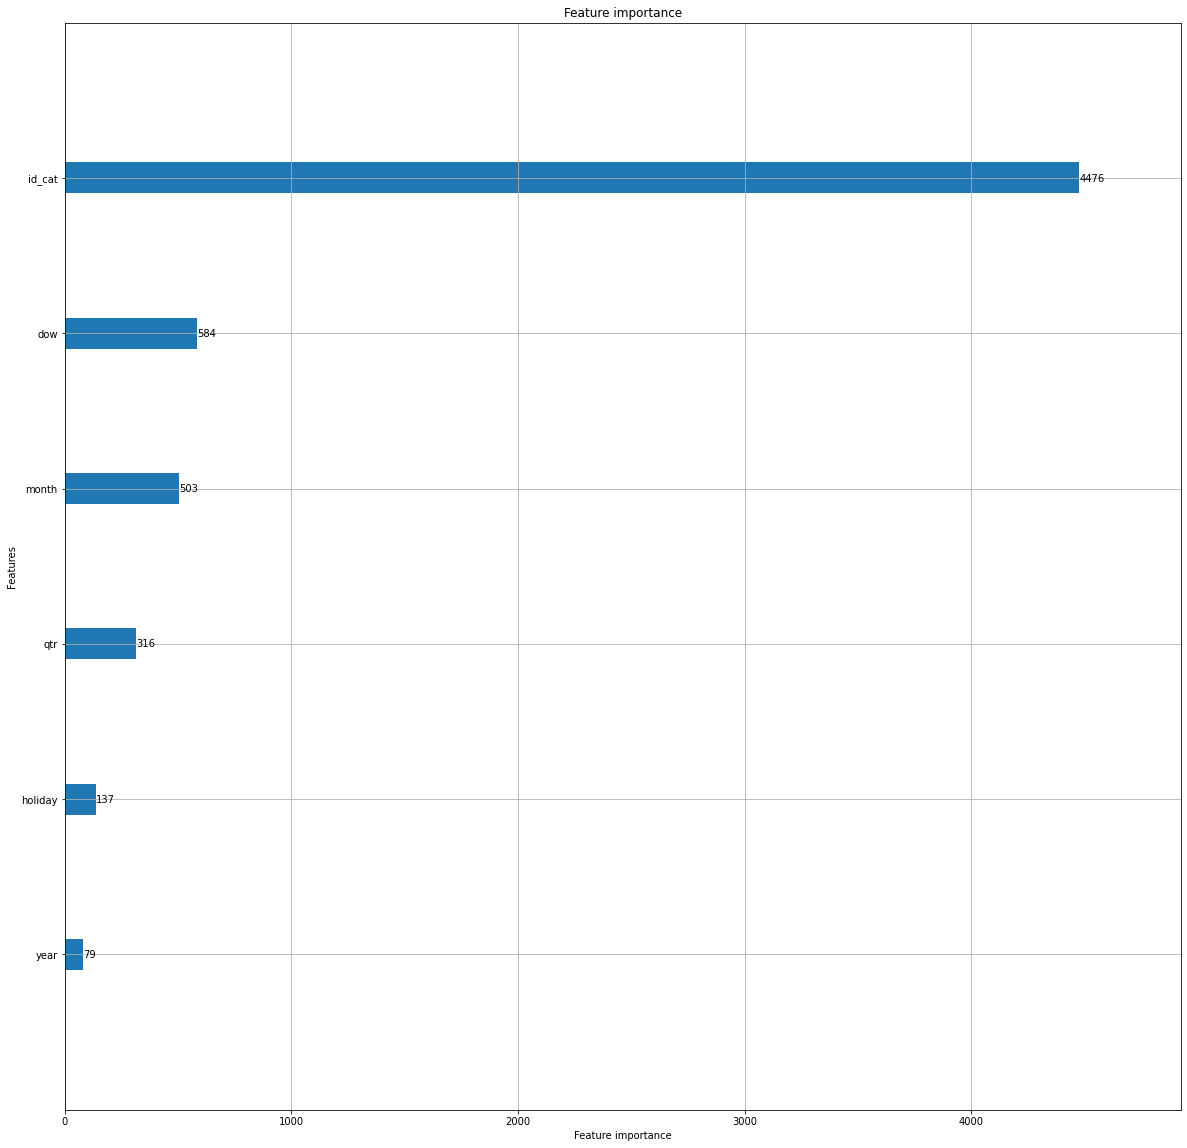

In [69]:
lgb.plot_importance(model, figsize=(20, 20))

In [37]:
! pip install category_encoders

     |████████████████████████████████| 81kB 3.2MB/s 
